# [Problem 1] Classifying fully connected layers

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.metrics import confusion_matrix

In [23]:
from keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [3]:
X_train = X_train.reshape(-1, 784)
X_test = X_test.reshape(-1, 784)

X_train = X_train.astype(np.float)
X_test = X_test.astype(np.float)
X_train /= 255
X_test /= 255

from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_train_one_hot = enc.fit_transform(y_train[:, np.newaxis])
y_test_one_hot = enc.transform(y_test[:, np.newaxis])

from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train_one_hot, test_size=0.2)

In [4]:
class FC:
    """
    All coupling layers from n_nodes1 to n_nodes2
    Parameters
    ----------
    n_nodes1 : int
      Number of nodes in previous layer
    n_nodes2 : int
      Number of nodes in the next layer
    initializer : instance of initialization method
    optimizer : instance of optimization method
    """
    def __init__(self, n_nodes1, n_nodes2, initializer, optimizer):
        # Initialization
        # Use the initializer method to initialize self.W and self.B
        self.n_nodes1 = n_nodes1
        self.n_nodes2 = n_nodes2
        self.optimizer = optimizer
        self.W = initializer.W(self.n_nodes1, self.n_nodes2)
        self.B = initializer.B(self.n_nodes2)
        
    def forward(self, X):
        """
        Forward
        Parameters
        ----------
        X : ndarray of the following form, shape (batch_size, n_nodes_bf)
            Input
        Returns
        ----------
        A : ndarray of the following form, shape (batch_size, n_nodes_af)
            Outputs
        """
        self.X = X
        #display(self.X.shape)
        #display(self.W.shape)
        #display(self.B.shape)
        A = np.dot(self.X, self.W) +  self.B
        #display(A.shape)
        return A

    def backward(self, dA):
        """
        Backward
        Parameters
        ----------
        dA : ndarray of the following form, shape (batch_size, n_nodes2)
            Gradient flowed from behind
        Returns
        ----------
        dZ : ndarray of the next shape, shape (batch_size, n_nodes1)
            Gradient flowing forward
        """
        dB = np.sum(dA, axis=0)
        dW = np.dot(self.X.T, dA)
        dZ = np.dot(dA, self.W.T)     

        # Update
        #self = self.optimizer.update(dW, dB, self.W, self.W)
        self.W = self.optimizer.update(dW, self.W)
        self.B = self.optimizer.update(dB, self.B)

        return dZ

# [Problem 2] Classifying the initialization method

In [5]:
class SimpleInitializer:
    """
    Simple initialization with Gaussian distribution
    Parameters
    ----------
    sigma : float
      Standard deviation of the Gaussian distribution
    """
    def __init__(self, sigma):
        self.sigma = sigma
        #display(self.sigma.Calc)
    def W(self, n_nodes1, n_nodes2):
        """
        Initialization of weights
        Parameters
        ----------
        n_nodes1 : int
          Number of nodes in the previous layer
        n_nodes2 : int
          Number of nodes in the next layer

        Returns
        ----------
        W :
        """
        W = self.sigma * np.random.randn(n_nodes1, n_nodes2)
        return W
    
    def B(self, n_nodes2):
        """
        Bias initialization
        Parameters
        ----------
        n_nodes2 : int
          Number of nodes in the next layer

        Returns
        ----------
        B :
        """
        B = self.sigma * np.random.randn(1, n_nodes2)
        return B

# [Problem 3] Classifying optimization methods

In [6]:
class SGD:
    """
    Stochastic gradient descent method
    Parameters
    ----------
    lr : learning rate
    """
    def __init__(self, lr):
        self.lr = lr

    def update(self, dWorB, WorB):
        """
        Update the weights and biases of a layer
        Parameters
        ----------
        layer : the instance of the layer before the update

        Returns
        ----------
        layer : the instance of the layer after the update

        Translated with www.DeepL.com/Translator (free version)
        """
        self.WorB = WorB
        self.WorB -= self.lr*dWorB
        return self.WorB

# [Problem 4] Classifying activation functions

In [7]:
class Activation:
    """
    Activation function tanh
    Parameters
    ----------
    """
    def __init__(self, how_act):
        self.how_act = how_act
    
    def forward(self, X):
        """
        Forward
        Parameters
        ----------
        X : ndarray of the following form, shape (batch_size, n_nodes_bf)
            Input
        Returns
        ----------
        A : ndarray of the following form, shape (batch_size, n_nodes_af)
            Outputs
        """
        self.X = X
        if self.how_act is "tanh":
            Z = np.tanh(self.X)
        elif self.how_act is "relu":
            Z = np.clip(self.X, 0, None)             
        return Z

    def backward(self, dZ):
        """
        Backward
        Parameters
        ----------
        dA : ndarray of the following form, shape (batch_size, n_nodes2)
            The gradient flowed from behind
        Returns
        ----------
        dZ : ndarray of the next shape, shape (batch_size, n_nodes1)
            Gradient flowing forward
        """
        if self.how_act is "tanh":
            dA = dZ * (1 - np.tanh(self.X)**2)
        elif self.how_act is "relu":
            dA = dZ * np.clip(np.sign(self.X), 0, None)
            #if dZ>0:
            #    dA = 1
            #else:
            #    dA =0            
        return dA

    def softmax_fw(self, X, y):
        """
        Forward
        Parameters
        ----------
        X : ndarray of the following form, shape (batch_size, n_nodes_bf)
            Input
        Returns
        ----------
        A : ndarray of the following form, shape (batch_size, n_nodes_af)
            Outputs
        """     
        Z = np.exp(X) / np.sum(np.exp(X), axis=1).reshape(-1,1)
        return Z

    def softmax_bw(self, Z, y):
        """
        Backward
        Parameters
        ----------
        dA : ndarray of the following form, shape (batch_size, n_nodes2)
            The gradient flowed from behind
        Returns
        ----------
        dZ : ndarray of the next shape, shape (batch_size, n_nodes1)
            Gradient flowing forward
        """
        dA = Z - y
        return dA

    def entropy(self, Z, y):
        """
        Forward
        Parameters
        ----------
        X : ndarray of the following form, shape (batch_size, n_nodes_bf)
            Input
        Returns
        ----------
        A : ndarray of the following form, shape (batch_size, n_nodes_af)
            Outputs
        """     
        L = -1*np.average(np.sum(y * np.log(Z), axis=1), axis=0)
        return L

# [Problem 5] ReLU class creation

In [8]:
class Relu:
    """
    Activation function tanh
    Parameters
    ----------
    """
    def __init__(self):
        pass
    def forward(self, X):
        """
        forward(self, X)
        Parameters
        ----------
        X : ndarray of the following form, shape (batch_size, n_nodes_bf)
            Input
        Returns
        ----------
        A : ndarray of the following form, shape (batch_size, n_nodes_af)
            Outputs
        """     
        if X>0:
            Z = X
        else:
            Z =0            
        return Z

    def backward(self, dZ):
        """
        Backward
        Parameters
        ----------
        dA : ndarray of the following form, shape (batch_size, n_nodes2)
            The gradient flowed from behind
        Returns
        ----------
        dZ : ndarray of the next shape, shape (batch_size, n_nodes1)
            Gradient flowing forward
        """
        if dZ>0:
            dA = 1
        else:
            dA =0            
        return dA

# [Problem 6] Initial value of weight

In [9]:
class Sigma_ini:
    """
    Activation function tanh
    Parameters
    ----------
    """
    def __init__(self, n, how_act):
        self.n=n
        self.how_act = how_act
    #def calc(self):
        if self.how_act is "tanh":
            self.calc = 1/np.sqrt(self.n)
        elif self.how_act is "relu":
            self.calc = np.sqrt(2/self.n)
    #    return self.calc

In [10]:
class He:
    """
    Activation function tanh
    Parameters
    ----------
    """
    def __init__(self,n):
        self.n=n
    def _Calc(self):
        """
        Forward
        Parameters
        ----------
        n : ndarray of the following form, shape (batch_size, n_nodes_bf)
            Input
        Returns
        ----------
        siguma : ndarray of the following form, shape (batch_size, n_nodes_af)
            Outputs
        """     
        siguma = np.sqrt(2/self.n)            
        return siguma

# [Problem 7] Optimization method

In [11]:
class AdaGrad:
    """
    Stochastic gradient descent method
    Parameters
    ----------
    lr : learning rate
    """
    def __init__(self, lr):
        self.lr = lr
    def update(self, layer, d_):
        """
        Update the weights and biases of a layer
        Parameters
        ----------
        layer : the instance of the layer before the update

        Returns
        ----------
        layer : the instance of the layer after the update
        """
        self.H += d_**2
        layer -= self.lr*d_/np.sqrt(self.H)
        return layer

# [Problem 8] Class completion

In [12]:
class GetMiniBatch:
    """
    Iterator to retrieve the mini-batch

    Parameters
    ----------
    X : ndarray of the following form, shape (n_samples, n_features)
      Training data
    y : ndarray of the following form, shape (n_samples, 1)
      The correct answer value
    batch_size : int
      batch size
    seed : int
      Seed of random number in NumPy
    """
    def __init__(self, X, y, batch_size = 20, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self._X = X[shuffle_index]
        self._y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)

    def __len__(self):
        return self._stop

    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self._X[p0:p1], self._y[p0:p1]        

    def __iter__(self):
        self._counter = 0
        return self

    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self._X[p0:p1], self._y[p0:p1]

In [13]:
class ScratchSimpleNeuralNetrowkClassifier():
    """
    A simple three-layer neural network classifier

    Parameters
    ----------
    bp : int
        Number of backpropagations
    Attributes
    ----------
    """
    def __init__(self, how_act="tanh", n_dims=4, n_output=10, n_epoq=5, batch_size=100, 
                 lr=0.01, verbose = True):
        self.verbose = verbose
        self.n_epoq = n_epoq
        self.n_dims = n_dims
        self.n_output = n_output
        self.batch_size = batch_size
        self.how_act = how_act
        self.lr = lr
        self.loss_list = np.array([])
        self.loss_val_list = np.array([])

    def fit(self, X, y):
        """
        Trains a neural network classifier.

        Parameters
        ----------
        X : ndarray of the following form, shape (n_samples, n_features)
            Features of the training data.
        y : ndarray of the following form, shape (n_samples, )
            The correct answer value of the training data
        """
        self.n_features = X.shape[1]
        self.optimizer = SGD(self.lr)
        
        self._make_dim()
    
        self.val = 0
        get_mini_batch = GetMiniBatch(X, y, batch_size=self.batch_size)
        for _ in range(self.n_epoq):
            for X_mini, y_mini in get_mini_batch:
                self.X_ = X_mini
                self.y_ = y_mini
                self._forward_propagation()
                self._back_propagation()
                
            self.L = self.activation[self.n_dims].entropy(self.fw_nxt_input, self.y_)        
            self.loss_list = np.append(self.loss_list, self.L)
        
        if self.verbose:
            #When verbose is set to true, it outputs the learning process.
            pass
    
    def _make_dim(self):    
        self.sigma={}
        self.FC={}
        self.activation={}
        for i in range(self.n_dims):
            nodes = int(round(self.n_features/2**i, 0))
            self.sigma[i+1] = Sigma_ini(nodes, self.how_act)
            self.activation[i+1] = Activation(self.how_act)
            if i==self.n_dims-1:
                self.FC[i+1] = FC(nodes, self.n_output, SimpleInitializer(self.sigma[i+1].calc), self.optimizer)
            else:
                self.FC[i+1] = FC(nodes, int(round(nodes/2, 0)), SimpleInitializer(self.sigma[i+1].calc), self.optimizer)
    def _forward_propagation(self):
        self.fw_nxt_input = self.X_
        for n in range(1, self.n_dims+1):
            self.fw_nxt_input = self.FC[n].forward(self.fw_nxt_input)
            if n==self.n_dims:
                self.fw_nxt_input = self.activation[n].softmax_fw(self.fw_nxt_input, self.y_)
                break
            #display(self.fw_nxt_input)
            self.fw_nxt_input = self.activation[n].forward(self.fw_nxt_input)
            #display(self.fw_nxt_input)
    def _back_propagation(self):
        for n in reversed(range(1, self.n_dims+1)):
            if n==self.n_dims:
                self.bw_nxt_input = self.activation[n].softmax_bw(self.fw_nxt_input, self.y_)
            else:
                self.bw_nxt_input = self.activation[n].backward(self.bw_nxt_input)
            #display(self.bw_nxt_input)
            self.bw_nxt_input = self.FC[n].backward(self.bw_nxt_input)
            #display(self.bw_nxt_input)
    def graph_cost_func(self):
        """
        Graph the loss trend.    
        If the data for verification is input, the loss trends for training and verification are superimposed and graphed.
        """
        plt.title("Num_of_Epoq vs Loss")
        plt.xlabel("Num_of_Epoq")
        plt.ylabel("Loss")
        plt.plot(range(1,self.n_epoq+1), self.loss_list, color="b", marker="o", label="train_loss")
        if self.val is 1:
            plt.plot(range(1,self.iter+1), self.loss_val_list, color="g", marker="+", label="val_loss")
        plt.grid()
        plt.legend()
        plt.show()
  
    def predict(self, X):
        """
        Estimation using a neural network classifier.
        Parameters
        ----------
        X : ndarray of the following form, shape (n_samples, n_features)
            Samples
            
        Returns
        -------
            ndarray of the following form, shape (n_samples, 1)
            Estimation results
        """
        self.fw_nxt_input = X
        for n in range(1, self.n_dims+1):
            self.fw_nxt_input = self.FC[n].forward(self.fw_nxt_input)
            if n==self.n_dims:
                self.fw_nxt_input = self.activation[n].softmax_fw(self.fw_nxt_input, self.y_)
                break
            self.fw_nxt_input = self.activation[n].forward(self.fw_nxt_input)
            
        return np.argmax(self.fw_nxt_input, axis=1)

In [14]:
scr_nnc = ScratchSimpleNeuralNetrowkClassifier("tanh",2)
scr_nnc.fit(X_train, y_train)

# [Problem 9] Learning and estimation

In [15]:
scr_nnc.predict(X_val)

array([8, 2, 8, ..., 5, 4, 3])

In [16]:
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.metrics import confusion_matrix

print("accuracy:{}".format(accuracy_score(y_test, scr_nnc.predict(X_test))))
print(" {}".format(confusion_matrix(y_test, scr_nnc.predict(X_test))))

accuracy:0.9569
 [[ 956    0    3    4    1    2    2    4    1    7]
 [   0 1126    2    2    0    1    1    0    2    1]
 [   4    3  981   25    6    0    0    7    3    3]
 [   0    1    3  991    1    4    0    4    2    4]
 [   0    0    3    2  940    0    3    6    0   28]
 [   6    1    1   43    1  826    3    2    5    4]
 [  10    3    9    2    5    7  911    6    4    1]
 [   0    4    7    7    2    0    0  987    0   21]
 [   3    6    5   42    8    7    3    6  885    9]
 [   3    5    0   13   11    1    1    7    2  966]]


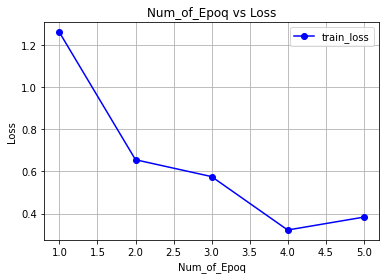

In [17]:
scr_nnc.graph_cost_func()

In [18]:
scr_nnc.loss_list

array([1.26207662, 0.65583915, 0.57562111, 0.32147311, 0.38278487])

In [19]:
scr_nnc2 = ScratchSimpleNeuralNetrowkClassifier("relu",2)
scr_nnc2.fit(X_train, y_train)

In [20]:
scr_nnc2.predict(X_val)

array([8, 5, 3, ..., 5, 4, 3])

In [21]:
print("relu_accuracy:{}".format(accuracy_score(y_test, scr_nnc2.predict(X_test))))
print("{}".format(confusion_matrix(y_test, scr_nnc2.predict(X_test))))

relu_accuracy:0.9757
[[ 966    1    1    2    2    1    1    2    2    2]
 [   0 1123    4    3    0    0    2    0    3    0]
 [   2    0 1010    6    5    0    1    4    4    0]
 [   1    0    1 1004    0    2    0    0    2    0]
 [   1    0    4    1  961    0    0    2    2   11]
 [   2    0    0   11    0  869    3    0    6    1]
 [   6    3    1    1   12    3  928    1    3    0]
 [   2    3   10   10    1    0    0  992    2    8]
 [   2    1    4   13    3    3    2    2  941    3]
 [   3    5    1   18    6    1    1    7    4  963]]


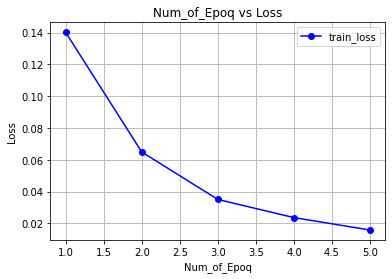

In [22]:
scr_nnc2.graph_cost_func()